In [ ]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy import optimize
from math import ceil, floor

# Variables

In [44]:
start_angle = 0
end_angle = 2 * np.pi
R_tool = 2  # radius of the bending tool
d_wire = 1  # diameter of the wire
R = 1  # R_tool + d_wire / 2
alpha_0 = (
    2 * np.pi / 200
)  # step angle in radiant. this is the value for most standard steppers with 1.8 deg
l_0 = (
    5.5 * alpha_0
)  # radius of the feeding tool multiplied with the minimum step angle of the stepper
n_min = 1

t, tau = smp.symbols("t, tau", nonnegative=True)
s = smp.symbols("s", nonnegative=True)
circle_start, circle_end, line_end = smp.symbols("circle_start,circle_end, line_end", nonnegative=True)


# Your functions

In [45]:
x_expr = R * t * smp.cos(t)
y_expr = R * t * smp.sin(t)

# Math

In [46]:

dtx_expr = x_expr.diff(t)
dty_expr = y_expr.diff(t)
ddtx_expr = dtx_expr.diff(t)
ddty_expr = dty_expr.diff(t)

x = smp.lambdify(t, x_expr, "numpy")
y = smp.lambdify(t, y_expr, "numpy")
dtx = smp.lambdify(t, dtx_expr, "numpy")
dty = smp.lambdify(t, dty_expr, "numpy")

curvature = (dtx_expr * ddty_expr - ddtx_expr * dty_expr) / (
    (dtx_expr**2 + dty_expr**2) ** (3 / 2)
)
curvature = curvature.simplify()

arc_length = smp.integrate(
    smp.sqrt(dtx_expr**2 + dty_expr**2), (tau, start_angle, t)
).simplify()
solution = smp.solve(smp.Eq(arc_length, s), t)
curvature_of_s_expr = curvature.subs(t, solution[0])

length: float = float(smp.N(
    arc_length.subs(t, end_angle)
 - arc_length.subs(t, start_angle)
))
n_max = ceil(length / l_0)

# calculate a general expression for the circle deviation as a function of the circle end point circle_end
circle_deviation = smp.integrate(curvature_of_s_expr - 1 / R, (s, circle_start, circle_end))
# turn the general expression into a numeric function
circle_deviation_f = smp.lambdify([circle_start, circle_end], circle_deviation, "scipy")
# calculate a general expression for the circle deviation as a function of the circle end point circle_end and the line end point line_end
line_deviation = smp.integrate(curvature_of_s_expr, (s, circle_end, line_end))
# turn the general expression into a numeric function
line_deviation_f = smp.lambdify([circle_end, line_end], line_deviation, "scipy")

# carry over any deviation of previous segments
carry_over_deviation = 0


In [47]:


def total_deviation(circle_start_f,circle_end_f, line_end_f):
    return (
        circle_deviation_f(circle_start_f, circle_end_f)
        + line_deviation_f(circle_end_f, line_end_f)
        + carry_over_deviation
    )


def has_root_constraint(circle_start_f, circle_end_f, line_end_f):
    # deviation for smallest possible line_end and deviation for largest possible line_end have different sign assuming there is only 1 root (decreasing curvature)
    # if the two results have a different sign, the function has a root. The constraint expects a value >0 if the constraint is fulfilled and <0 if not so we add a negative sign
    return - total_deviation(circle_start_f, circle_end_f, line_end_f) * total_deviation(circle_start_f, circle_end_f, length)
    


# start the calculation for circle_start=0
circle_start_f = 0


circle_end_p = np.linspace(0, length, n_max)
line_end_p = np.linspace(0, length, n_max)
def plot_deviation(s_0):
    # calculate the total deviation for circle_start_f for all circle_end and line_end in circle_end_p and line_end_p
    total_deviation_p = np.vectorize(total_deviation)(circle_start_f, circle_end_p[:, np.newaxis], line_end_p)
    # plot the deviation as a surface over circle_end_p and line_end_p
    plt.figure()
    plt.title("deviation")
    plt.xlabel("circle_end")
    plt.ylabel("line_end")
    # surface plot
    plt.contourf(circle_end_p, line_end_p, total_deviation_p, 100)
    plt.colorbar()
    plt.show()

# Generate Segments

In [48]:
segments = [0] ## first segment start point is 0
circle_start_f=0
while circle_start_f < length:
    print("calculating first end point circle_end")
    
    circle_end_min_f = circle_start_f + n_min*R*alpha_0

    # find the circle end point for which the deviation is zero at the given circle_start   
    try: 
        circle_end_f = scp.optimize.root_scalar(
            lambda circle_end: circle_deviation_f(circle_start_f, circle_end)+carry_over_deviation,
            x0=circle_end_min_f,
            bracket=[circle_end_min_f, length-l_0], # boundaries for the arc end position
        ).root
    except ValueError:
        circle_end_f = circle_end_min_f
    # # round the end point to the nearest value that will be a multiple of the step angle R*alpha_0 to serve as starting point for the optimization
    circle_end_f = ceil(circle_end_f / alpha_0 / R) * alpha_0 * R

    # try different circle_end and find the shortest line_end where the total deviation will be 0
    def minimize_line_end(circle_end_f):
        # find the line end point line_end for which the total deviation of the arc and the line segment is zero
        try:
            return scp.optimize.root_scalar(
                lambda line_end_f: total_deviation(circle_start_f, circle_end_f, line_end_f),
                x0=circle_end_f + l_0, # initial guess
                bracket=[circle_end_f, length],
            ).root # returns the line end point line_end_f where the total deviation is minimized
        except ValueError:
            print("no root found")
            return length

    # find the circle end for which the total deviation is minimized
    circle_end_opt = scp.optimize.minimize(
        minimize_line_end, 
        circle_end_f, # initial guess
        constraints=({"type": "ineq", "fun": lambda circle_end : has_root_constraint(circle_start_f, circle_end,circle_end + l_0)}),
        bounds=scp.optimize.Bounds(circle_end_min_f, length, True),
    ).x[0]

    # find closest mechanically possible position circle_end for the end of the arc
    circle_end_opt = ceil(circle_end_opt / alpha_0 / R) * alpha_0 * R
    # calculate the optimal end point of the line segment line_end for the new circle_end
    line_end_opt = minimize_line_end(circle_end_opt)
    # round again
    line_end_opt = ceil(line_end_opt / l_0) * l_0

    # calculate any left over deviation resulting from mechanical limitations to consider in the next segments
    carry_over_deviation = total_deviation(circle_start_f, circle_end_opt,line_end_opt)
    # set the new start point
    circle_start_f = line_end_opt
    # add the new segments to the list of segments
    print("found new segments circle_end={}, line_end={}".format(circle_end_opt, line_end_opt))
    print("carry over deviation={}".format(carry_over_deviation))
    segments.extend([circle_end_opt, line_end_opt])

calculating first end point circle_end
found new segments circle_end=4.429645641561609, line_end=4.665265090580843
carry over deviation=0.026277218137387065
calculating first end point circle_end
found new segments circle_end=4.900884539600078, line_end=5.1836278784231595
carry over deviation=0.05356768089212474
calculating first end point circle_end
found new segments circle_end=5.46637121724624, line_end=5.701990666265475
carry over deviation=0.018717473855631328
calculating first end point circle_end
found new segments circle_end=5.906194188748811, line_end=6.220353454107791
carry over deviation=0.04959377446190824
calculating first end point circle_end
found new segments circle_end=6.4716808663949745, line_end=6.738716241950107
carry over deviation=0.022259164106897503
calculating first end point circle_end
found new segments circle_end=6.911503837897546, line_end=7.257079029792423
carry over deviation=0.06375709901279679
calculating first end point circle_end
found new segments ci

# Plotting

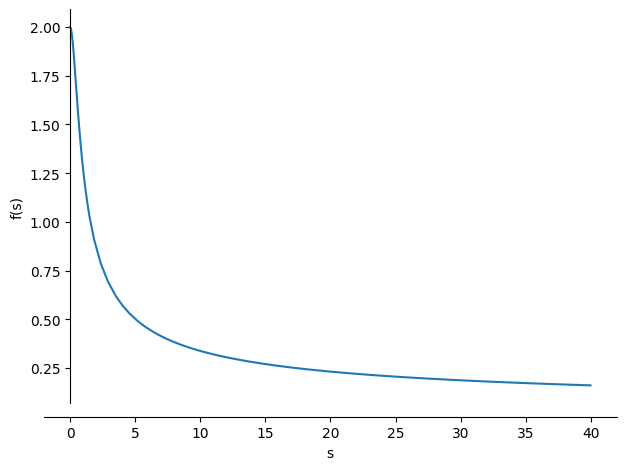

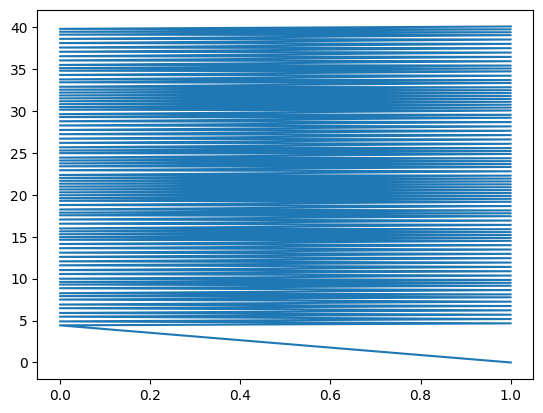